In [1]:
#loading in df 
import numpy as np 
df = np.load('/content/drive/MyDrive/Colab Notebooks/final_array.npy')
import numpy as np
data = df
# assume that `data` is a 5D numpy array with shape (n_samples, d1, d2, d3, d4)
print('Original shape:', data.shape)  # prints (2730, 5, 280, 280, 1)

# use numpy.reshape() to combine the first two dimensions along the first axis
data_reshaped = np.reshape(data, (data.shape[0]*data.shape[1], data.shape[2], data.shape[3], data.shape[4]))

# print the new shape
print('New shape:', data_reshaped.shape)  # prints (13650, 280, 280, 1)


Original shape: (2730, 5, 280, 280, 1)
New shape: (13650, 280, 280, 1)


In [2]:
#loading in one hot encoded list
#making cancer and benign list 
cancer_list = [3 for _ in range(82)]
#making benign list
benign_list = [2 for _ in range(148)]
combined_list = cancer_list + benign_list
combined_list[229]
#loading in the labels df 
import pandas as pd 
label = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Labels.csv")
#one hot encoding into one column 
label.loc[label['Normal'] == 1, 'one_hot_encoded_col'] = 0
label.loc[label['Actionable'] == 1, 'one_hot_encoded_col'] = 1
label.loc[label['Benign'] == 1, 'one_hot_encoded_col'] = 2
label.loc[label['Cancer'] == 1, 'one_hot_encoded_col'] = 3

# display the resulting dataframe
print(label)
#making list of the one hote encoded collumn 
#making list of first 3000 observations 
one_hot_encoded_list = label.iloc[:2500]['one_hot_encoded_col'].tolist()
one_hot_encoded_list = combined_list + one_hot_encoded_list
num_repeats = 5
one_hot_encoded_list = np.repeat(one_hot_encoded_list, num_repeats)

print(one_hot_encoded_list)


       PatientID    StudyUID  View  Normal  Actionable  Benign  Cancer  \
0     DBT-P00023  DBT-S04378  lmlo       0           1       0       0   
1     DBT-P00023  DBT-S04378  rmlo       0           1       0       0   
2     DBT-P00029  DBT-S00044  lmlo       1           0       0       0   
3     DBT-P00029  DBT-S00044  rmlo       1           0       0       0   
4     DBT-P00032  DBT-S04706  lmlo       1           0       0       0   
...          ...         ...   ...     ...         ...     ...     ...   
9483  DBT-P02569  DBT-S01802  rmlo       1           0       0       0   
9484  DBT-P04356  DBT-S00073  lmlo       1           0       0       0   
9485  DBT-P04356  DBT-S00073  rmlo       1           0       0       0   
9486  DBT-P01481  DBT-S01753  lmlo       1           0       0       0   
9487  DBT-P01481  DBT-S01753  rmlo       1           0       0       0   

      one_hot_encoded_col  
0                     1.0  
1                     1.0  
2                     0.0  

In [3]:
from collections import Counter

one_hot_encoded_counts = Counter(one_hot_encoded_list)
print(one_hot_encoded_counts)

Counter({0.0: 10640, 1.0: 1790, 2.0: 790, 3.0: 430})


In [4]:
data_reshaped.shape

(13650, 280, 280, 1)

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16

if tf.test.is_gpu_available():
    print('GPU available:')
    # Print the name of the GPU(s) available
    for gpu in tf.config.list_physical_devices('GPU'):
        print(gpu)
    # Set TensorFlow to use the first GPU
    tf.config.set_visible_devices(gpu, 'GPU')
else:
    print('No GPU available.')

# Load the DICOM array (assuming it has shape [num_images, height, width, num_channels])
dicom_array = data_reshaped
labels = one_hot_encoded_list

# Repeat single channel 3 times to create 3-channel input
dicom_array = np.repeat(dicom_array, 3, axis=-1)

# Convert labels to one-hot encoded vectors
labels = np.asarray(labels)
labels = labels.astype(np.int32)
num_classes = np.max(labels) + 1  # Add 1 to account for 0-indexing
labels_one_hot = tf.keras.utils.to_categorical(labels, num_classes)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    dicom_array, labels_one_hot, test_size=0.2, random_state=42, stratify=labels
)




Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU available:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [6]:
input_shape = (280, 280, 3)

# Load the pre-trained 2D ResNet50 model, excluding the top layer
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape
)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = True

# Custom model to handle the 4D input
input_shape = (280, 280, 3)
input_layer = layers.Input(shape=input_shape, name="input")
x = base_model(input_layer)
x = layers.Conv2D(64, kernel_size=( 3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(pool_size=( 2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
output_layer = layers.Dense(num_classes, activation='softmax', name="output")(x)

# Create the model
model = keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model with your data
history = model.fit(X_train, y_train, epochs=10, batch_size=8, validation_split=0.2)

58889256/58889256 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 280, 280, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 64)          294976    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 64)         0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 64)         256       
 ormalization)                                                   
                                                              

86/86 [==============================] - 4s 29ms/step
Overall Accuracy: 0.89
Overall Sensitivity: 0.80
Overall Specificity: 0.92
Overall F1-score: 0.82


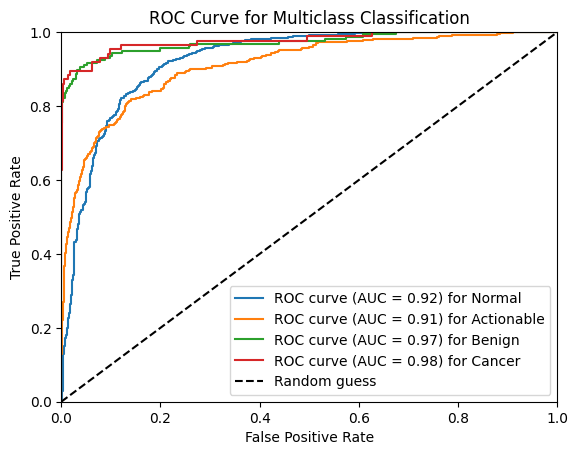

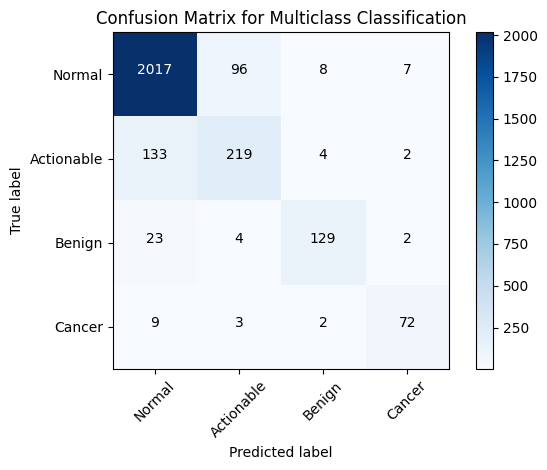

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import numpy as np
import itertools

y_pred = model.predict(X_test)
# Calculate AUC-ROC score
auc = roc_auc_score(y_test, y_pred, multi_class='ovr')

# Calculate confusion matrix
y_true_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Calculate sensitivity and specificity for each class
num_classes = y_test.shape[1]
sensitivity = []
specificity = []
for i in range(num_classes):
    true_positives = cm[i,i]
    false_positives = cm[:,i].sum() - true_positives
    false_negatives = cm[i,:].sum() - true_positives
    true_negatives = cm.sum() - true_positives - false_positives - false_negatives
    
    sensitivity.append(true_positives / (true_positives + false_negatives))
    specificity.append(true_negatives / (true_negatives + false_positives))

# Calculate overall accuracy, sensitivity, specificity, and F1-score
overall_accuracy = accuracy_score(y_true_classes, y_pred_classes)
overall_sensitivity = np.mean(sensitivity)
overall_specificity = np.mean(specificity)
overall_f1_score = f1_score(y_true_classes, y_pred_classes, average='macro')

# Print overall metrics
print(f'Overall Accuracy: {overall_accuracy:.2f}')
print(f'Overall Sensitivity: {overall_sensitivity:.2f}')
print(f'Overall Specificity: {overall_specificity:.2f}')
print(f'Overall F1-score: {overall_f1_score:.2f}')

# Plot ROC curve
class_names = ['Normal', 'Actionable', 'Benign', 'Cancer']
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = roc_auc_score(y_test[:, i], y_pred[:, i])
    plt.plot(fpr[i], tpr[i], label='ROC curve (AUC = %0.2f) for %s' % (roc_auc[i], class_names[i]))

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")

plt.show()

# Plot confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Multiclass Classification')
plt.colorbar()

tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

plt.show()


In [ ]:
print(sensitivity)

[0.9478383458646616, 0.611731843575419, 0.8164556962025317, 0.8372093023255814]


In [ ]:
print(specificity)

[0.7259136212624585, 0.9565767284991569, 0.994556765163297, 0.995839636913767]
